Repositorio: https://github.com/acabreraufrj/modelagem,   - - - - - -     [< abrir em binder >](https://mybinder.org/v2/gh/acabreraufrj/modelagem/master?filepath=aulas%2FAula15.ipynb)

# Aula 15:  exemplos de modelagem com EDP

## Objetivos:

- ver alguns exemplos concretos de modelagem com EDP, incluindo validação de modelos

# Lembremos: Modelagem = 1+2+3

![](./figs/diagr_modelagem_def.jpg)

1) abstraemos alguma situação concreta a um modelo onde a quantidade a estudar é uma função de varias variáveis $u(x_1,..,x_d)$ e propomos que ela deve ser solução de uma EDP (com certas condições de bordo/iniciais)

2) achamos uma aproximação numérica à solução exata desta EDP (via diferenças finitas em lugar de infinitesimais)

3) validamos esta predição com resultados de experimentos ou comparando com soluções esperadas

# Esfriando uma taça de café

- Consideremos uma caneca isolante cilindrica que possui um liquido (agua ou café) a uma temperatura inicial $T_0$ que é homogenea no cilindro. 

- Pensamos que a temperatura evolui com o tempo $t$ e que é homogenea nas fatias horizontais. Logo, nossa incógnita é a temperatura $T\equiv T(t,y)$ onde $y\in [0,h]$ representa a altrua desde o fundo da caneca.

**Obs**: em geral, se considera que a temperatura é homogenea para todo tempo $t$ (ou seja, $T$ independente de $y$) e tem-se uma lei ODE efeitiva para a evolução da temperatura com $t$: [**Lei de resfriamento de Newton**](https://en.wikipedia.org/wiki/Newton%27s_law_of_cooling)
$$ \frac{dT}{dt} \propto (T_{amb}-T)$$
onde $T_{amb}$ é a temperatura ambiente (assumida constante).

- vamos fazer um outro modelo sem assumir independencia de $y$ baseado na eq. de difusão do calor:
$$ \frac{\partial T}{\partial t} = c \frac{\partial^2 T}{\partial y ^2}$$
com $c$ ("[thermal diffusivity](https://en.wikipedia.org/wiki/Thermal_diffusivity)").


- as condições de contorno/iniciais são:
$$ T(t=0, y) = T_0 \ \forall y $$
$$ \partial_yT(t, y=0) =0, \forall t \text{ nao tem transferencia de calor no fundo}$$
$$ T(t,y=h) = T_{amb} $$

**Obs**: $c=1.43 \times 10^{−7} m^2/s$ para agua a $25^oC$. O [comportamento com a temperatura](https://www.engineeringtoolbox.com/water-steam-thermal-diffusivity-d_2058.html) é:
![](./figs/therm_difus_agua.png)
Podemos assumir constante no nosso problema $T\in[25,80]$

## Construimos a solução aproximada com diferencias finitas

usamos 2 pontos "ghost" em $y=-\Delta y$ e $y=h +\Delta y$ para incorporar as condições de bordo

(lembrar da aula passada!)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation
import scipy.integrate as integrate

In [2]:
h=8.5 # cm; caneca com 8.5cm de altura

tmax = 10*60 # seg    
nx = 400    
dx = h/nx   
c = 1.43*10**(-7)*10**4 # cm^2/seg; um chute inicial baseado no valor tabulado
nt = 10000
dt = tmax/nt

T0=81 # grados C
Tamb=25 # grados C
Tcup = 15

In [3]:
dt

0.06

### cuidado: se $\Delta t$ é muito grande, a aprox. numerica explode e se comporta mal...

In [4]:
# funcoes que convertem indices de discretizaçao em variaveis originais
ot = lambda it: it*dt
ox = lambda ix: (ix-1)*dx

It = [ot(it) for it in range(nt)]
Ix = [ox(ix) for ix in range(nx)]

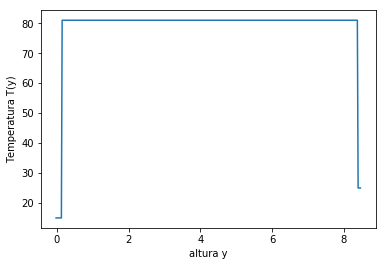

In [5]:
# condições iniciais
def cond_inic_cafe(nx,T0,Tamb,Tcup):
    u = np.zeros(nx)
    unew = np.zeros(nx)
    uxx = np.zeros(nx)
    for ix in range(nx):
        u[ix] = T0  # u(0,x)=f(x)
    for i in range(int(nx*0.99),nx):
        u[i]=Tamb # o ponto ghost para o extremo y=h tem temperatura ambiente
    for i in range(int(nx*0.02)):
        u[i]=Tcup # temperatura do fundo da caneca
    plt.plot(Ix,u)
    plt.xlabel('altura y')
    plt.ylabel('Temperatura T(y)')
    plt.show()
    return u,unew,uxx

u,unew,uxx = cond_inic_cafe(nx,T0,Tamb,Tcup)

In [6]:
# Evolução temporal
def evol_temp_cafe(nt,nx,dt,dx,c,m,u,unew,uxx,Tamb):
    uts = []
    uts.append(u)
    for im in range(m):
        for it in range(nt):
            uxx[1:nx-1] = u[2:nx] - 2*u[1:nx-1] + u[:nx-2]
            uxx /= dx ** 2
            unew =  u + dt * c * uxx
            #condicoes de contorno
            unew[0]=unew[2] # d_x u(t,y=0) = 0, ix=0 ponto ghost
            unew[nx-1] = Tamb # u(t,y=h) =Tamb
            u = unew
        uts.append(u) # guardamos u cada Tmax transcurrido
    return uts

m = 6  #vezes que vamos concatenar evolucao ate tmax
uts = evol_temp_cafe(nt,nx,dt,dx,c,m,u,unew,uxx,Tamb)

In [7]:
# plotando tudo t mapsto ut
def plotar_uts(isnap,tmax,T0,Ix,uts):
    m = len(uts)
    intervalo = range(m)
    for it in intervalo:
        if it % isnap == 0:    # se isnap é maior, temos menos frames
            leg = 't='+ str(int(100*tmax*(it)/60)/100) +'min'
            plt.ylim(ymin=0,ymax=T0+5)
            plt.plot(Ix,uts[it],label=leg)
            plt.legend()
            clear_output(wait = True)
            plt.pause(0.1)
    # temperatura media final
    ulast = uts[len(uts)-1]
    umean_x = sum(ulast)/len(ulast)
    print('temperatura y-media depois de '+'t='+ str(int(100*tmax*(m-1)/60)/100) +'min: ', umean_x)
    return


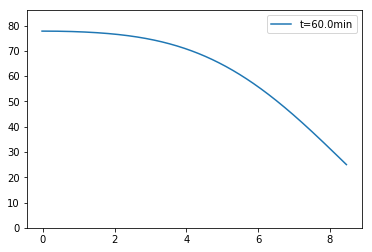

temperatura y-media depois de t=60.0min:  62.99173660577538


In [8]:
isnap = 1 
plotar_uts(isnap,tmax,T0,Ix,uts)

### comparar com: [ref](http://www-ucjf.troja.mff.cuni.cz/dolejsi/outreach/sedlacek_ajp.pdf)

![](./figs/resfriamento_cafe.png)

In [9]:
refts = [0,10,20,30,40,50,60,70,80] # min
refTemps = [80,68,57,50,44,41,39,37,35] # C

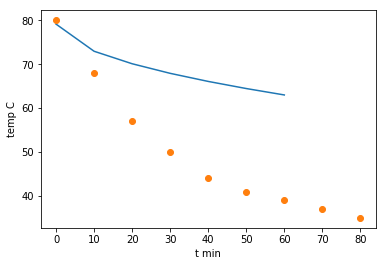

In [10]:
# vamos plotar temp y-media vs t
def comparar_com_ref_cafe(uts,tmax,refts,refTemps):
    umeans = []
    for i in range(len(uts)):
        umeans.append(sum(uts[i])/len(uts[i]))
    ts = [int(100*tmax*(it)/60)/100 for it in range(len(uts))] # em min
    plt.plot(ts,umeans)
    plt.plot(refts,refTemps,'o')
    plt.xlabel('t min')
    plt.ylabel('temp C')
    plt.show()
    return

comparar_com_ref_cafe(uts,tmax,refts,refTemps)

### vemos que como assumimos que a caneca é perfeitamente isolante, demora mais em resfriar
- vamos tentar incorporar perda de calor pelo bordo e fundo da caneca:

- - lateral:
$$ \frac{\partial T}{\partial t} = c \frac{\partial^2 T}{\partial y ^2} - k (T - T_{amb})$$
onde $k\sim 0$ reflete a pequena permeabilidade lateral da caneca ao calor ($k=0$ seria isolante perfeito).

- - fundo: 
trocamos $\frac{\partial T}{\partial y}(t,y=0) = 0$ por $\frac{\partial T}{\partial y}(t,y=0) = -\epsilon$ ($\epsilon > 0$ pequeno) permetindo que escape um pouco de calor pelo fundo

In [11]:
#evolucao nova
def evol_temp_cafe_new(nt,nx,dt,dx,c,m,u,unew,uxx,Tamb,k,eps):
    uts = []
    uts.append(u)
    for im in range(m):
        for it in range(nt):
            uxx[1:nx-1] = u[2:nx] - 2*u[1:nx-1] + u[:nx-2]
            uxx /= dx ** 2
            unew =  u + dt * c * uxx - k * (u-Tamb)
            #condicoes de contorno
            unew[0]=unew[2]+dx * eps # \d_x u(t,y=0) = eps, ix=0 ponto ghost
            unew[nx-1] = Tamb # u(t,y=h) =Tamb
            u = unew
        uts.append(u) # guardamos u cada Tmax transcurrido
    return uts


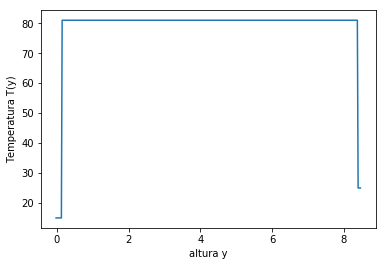

In [12]:
# parametros novos
k = 0.000015 # 1/seg
eps = -10 # C/cm

# nova simulaçao
u,unew,uxx = cond_inic_cafe(nx,T0,Tamb,Tcup)
m=6
uts = evol_temp_cafe_new(nt,nx,dt,dx,c,m,u,unew,uxx,Tamb,k,eps)

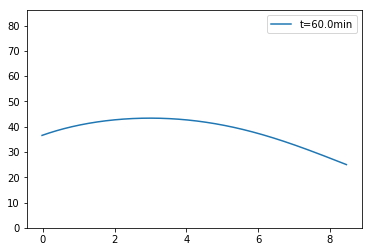

temperatura y-media depois de t=60.0min:  38.41662406002371


In [13]:
isnap = 1 
plotar_uts(isnap,tmax,T0,Ix,uts)

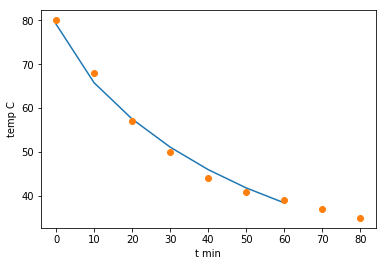

In [14]:
comparar_com_ref_cafe(uts,tmax,refts,refTemps)

# O modelo melhorou!!

# Estrutura populacional em função do tempo

[ Mathematical Models in Biology, Christina Kuttler](http://www-m6.ma.tum.de/~kuttler/script1.pdf), Seção 4.2


- possíveis idades $a > 0$
- numero de individuos com idade $a$ a tempo $t$: $u(a,t)$
- mortalidade dos individuos de idade $a$ por unidade de tempo: $\mu(a)$. Em geral, assume $\mu(a)\geq \mu_0 > 0$.
- EDP:
$$ \partial_t u (a,t) + \partial_a u (a,t) = - \mu(a) u(a,t) $$
“McKendrick-von Foerster equation”

**Obs**: é uma eq. de transporte (de "velhice")



- condição inicial: $u(a,t=0) = u_0(a)$ (distribuição inicial conhecida)
- condição de contorno: nascimentos
$$ u(0,t) = B(t)$$

- em geral, é complicado modelar $B(t)$ pois precisa de conhecer a taxa de nacimento $\beta(a)$ na idade $a$ *e a população $u(a,t)$*! ("condição de contorno não-local" em $a$)

- um modelo simplificado ("renewal equation") é $B(t)$ solução de:
$$ B(t) = \int_0^t \beta(a) B(t-a) e^{-\int_0^a \mu(s) ds}da+\int_t^\infty \beta(a)u_0(a-t)e^{-\mu(a)t}da$$

**Obs**: notar que esta é uma eq. integral não trivial para $B(t)$!

- para fazer a simulação numerica, discretizamos $B_j:= B(j\Delta t)$ com
$$ B_0= B(0) = \int_0^\infty \beta(a)u_0(a) da $$
e aproximamos a integral por uma soma ($j\geq 1$)
$$ B_j = \beta(0) B_j \Delta t + \sum_{k=1}^j \beta(k\Delta t) B_{j-k} e^{-\int_0^{k\Delta t}\mu(s)ds} \Delta t + \int_{j\Delta t}^\infty \beta(a)u_0(a-t)e^{-\mu(a)t}da $$
- colocamos $\Delta a = \Delta t$ na discretização

# Cuidado:

- a equação $\partial_t u + \partial_a u = f$ pode ser instável numéricamente dependendo dos valores de $\Delta t, \Delta a$
- a aprox. numerica desenvolve singularidades em alguns casos
![](./figs/desenv_sing_numer.png)
- um criterio de estabilidade é $0\leq \Delta t/\Delta a \leq 1$ ("Courant number") [ [ Ref] ](http://indico.ictp.it/event/a06220/session/18/contribution/10/material/0/2.pdf)

In [905]:
# parametros
nt =500
dt = 1/10 #anos
tmax = nt*dt
edadmax = 100 #anos
da = 2/12/1
na = int(edadmax/da)
ot = lambda j: j*dt
oa = lambda j: j*da
It = [ot(j) for j in range(nt)]
Ia = [oa(j) for j in range(na)]

mu0 = 3/edadmax/dt # indiv/anos
def mu(a):
    ret = mu0
    if a >50:
        ret *=2
    return ret
beta0 = 0.04 # indiv/anos
beta = lambda a: beta0

print('dt/da=',dt/da) # estabilidade se dt/da entre 0 e 1 
# http://indico.ictp.it/event/a06220/session/18/contribution/10/material/0/2.pdf
print('tmax=',tmax)

dt/da= 0.6000000000000001
tmax= 50.0


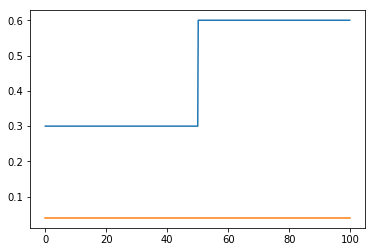

In [906]:
plt.plot(Ia,[mu(a) for a in Ia])
plt.plot(Ia, [beta(a) for a in Ia])

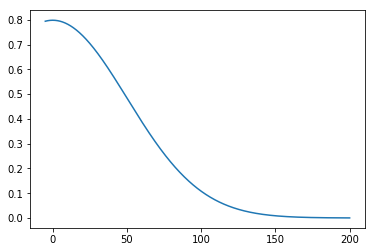

In [907]:
# a funcao gaussiana para a condicao inicial
def normal(x,sigma,mu):
    ret = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )
    return ret
sigma=50
muu=0
minorm = lambda x:100* normal(x,sigma,muu)
intx=np.linspace(-5,200,1000)
plt.plot(intx,[minorm(x) for x in intx])
plt.show()


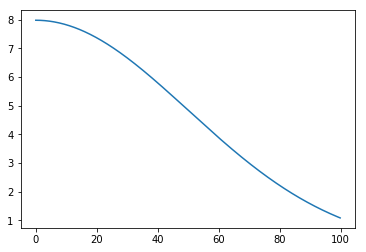

populacao total inicial: 2866.94812155029


In [908]:
#inicializando variaveis e cond inicial
u0 = np.zeros(na)
for j in range(na):
    u0[j] = 10* minorm(j*da)
def u0fun(a):
    ret = 0
    j = int(a/da)
    if j in range(na):
        ret = u0[j]
    return ret
#u0funsuave = lambda a: integrate.quad(lambda x: u0[int(x/dt)]*minorm(x-a), 0,100)[0]
#for j in range(n):
#    u0[j] = u0funsuave(j*dt)
plt.plot(Ia,u0)
plt.show()
print('populacao total inicial:', sum(u0))


In [910]:
# definicoes auxiliares
u = np.zeros(na)
unew = np.zeros(na)
B = np.zeros(nt)

into2 = lambda a,t: beta(a)*u0fun(a-t)*np.exp(-mu(a)*t)
Int2 = lambda t: integrate.quad(lambda a: into2(a,t),t,oa(na))[0]
intmu = lambda a: integrate.quad(lambda s: mu(s), 0,a)[0]
muind = np.zeros(na)
for j in range(na):
    muind[j] = mu(j*dt)
intR = integrate.quad(lambda a: beta(a)*np.exp(-intmu(a)),0,edadmax)[0]
#oa(na)
print('nacimentos a t=0:', Int2(0))

nacimentos a t=0: 19.113039061056554


In [912]:
# evoluçao temporal aproximada
B[0] = Int2(0)
uts=[]
u[:] = u0[:]
u[0]=B[0]
uts.append(list(u0))
print('pop. inic.=', sum(u0), ', nacim. B(t=0)=',B[0])
for j in range(1,nt):
    #calculando B(t)
    soma = 0
    for k in range(1,j+1):
        soma += beta(k*dt)*B[j-k]*np.exp(-intmu(k*dt))*dt
    B[j] = (soma + Int2(j*dt))/(1-beta(0)*dt)
    # evolucao
    unew[1:na-1] = u[1:na-1] - (dt/da)* (u[1:na-1] - u[:na-2])  - dt * muind[1:na-1] * u[1:na-1]
    # condiçao de contorno u(a=0,t=jdt)=B(jdt)
    unew[0] = B[j]
    u[:] = unew[:]
    uts.append(list(u))
print('poptot final','=', sum(uts[nt-1]))

pop. inic.= 2866.94812155029 , nacim. B(t=0)= 19.113039061056554
poptot final = 0.003367488556515783


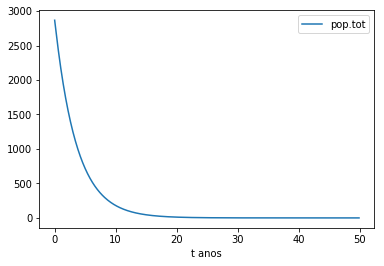

In [913]:
# evolução da populaçao total
plt.plot(It,[sum(uts[t]) for t in range(nt)],label='pop.tot')
plt.xlabel('t anos')
plt.legend()
plt.show()

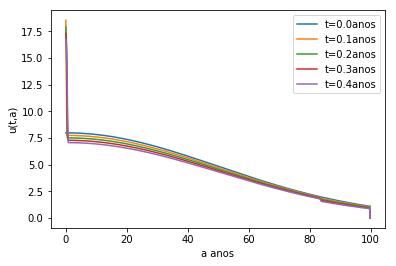

In [914]:
# as primeiras distribuições para t pequeno
for i in range(5):
    plt.plot(Ia,uts[i],label='t='+str(int(i*dt*100)/100)+'anos')
plt.xlabel('a anos')
plt.ylabel('u(t,a)')
plt.legend()
plt.show()

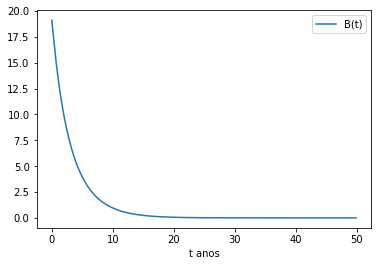

In [915]:
# a função de nascimentos B(t)
plt.plot(It,[B[j] for j in range(nt)], label='B(t)')
plt.xlabel('t anos')
plt.legend()
plt.show()

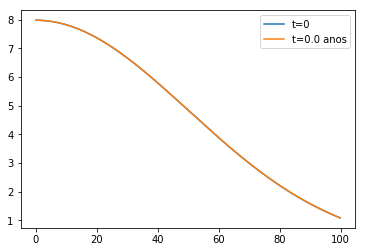

populacao total final: 3623.2223982766122


In [872]:
# plotando tudo t mapsto ut
def plotar_uts_popul(isnap,It,tm,uts):
    m = int(tm/dt)
    intervalo = range(m)
    deltat = tm/(m-1) #anos
    for it in intervalo:
        if it % isnap == 0:    # se isnap é maior, temos menos frames
            leg = 't='+ str(it*deltat) +' anos'
            #plt.ylim(ymin=0,ymax=max(uts[0]))
            plt.plot(Ia,uts[0],label='t=0')
            plt.plot(Ia,uts[it],label=leg)
            plt.legend()
            clear_output(wait = True)
            plt.pause(0.1)
    # populacao total final
    ulast = uts[m-1]
    utotfin = sum(ulast)
    print('populacao total final:', utotfin)
    return

isnap =50
plotar_uts_popul(isnap, It, tmax, uts)


In [879]:
# gerando um gif
def gerar_gif(isnap, tempos, uts, nome_arch, intervalo_gif): 
    fig, ax = plt.subplots()
    ax.plot(uts[0])
    def update(i):
        label = 't='+ str(int(100*(i*dt))/100) +'anos'
        ax.clear()
        ax.plot(Ia,uts[0])
        ax.plot(Ia,uts[i])
        ax.set_xlabel(label)
        return ax
    anim = FuncAnimation(fig, update, frames=tempos, interval=intervalo_gif)
    anim.save('./figs/'+ nome_arch +'.gif', dpi=80, writer='imagemagick')
    
isnap = 50    # frequencia de ploteo
tempos = [it for it in range(nt) if it % isnap == 0]
intervalo_gif = 50*len(tempos) # quanto maior o intervalo_gif, mais tempo vai ficar em cada frame na reproducao
#gerar_gif(isnap,tempos,uts,'populacao_morre',intervalo_gif)


![](./figs/populacao_morre.gif)

## com estes parametros, a populacao eventualmente morre 

## vamos variar os parametros, dando mais forca aos nascimentos

In [916]:
beta0 = 0.35 # era 0.04
beta = lambda a: beta0
nt=100 # era 500
tmax = nt*dt
It = [ot(j) for j in range(nt)]
print('tmax',tmax)

tmax 10.0


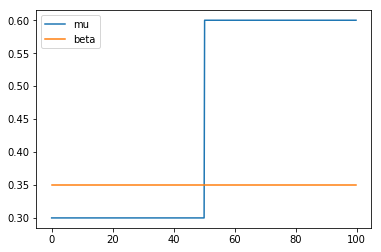

In [917]:
# plotando mu e beta
plt.plot(Ia,[mu(a) for a in Ia],label='mu')
plt.plot(Ia, [beta(a) for a in Ia],label='beta')
plt.legend()
plt.show()

In [918]:
# definicoes auxiliares
u = np.zeros(na)
unew = np.zeros(na)
B = np.zeros(nt)

into2 = lambda a,t: beta(a)*u0fun(a-t)*np.exp(-mu(a)*t)
Int2 = lambda t: integrate.quad(lambda a: into2(a,t),t,oa(na))[0]
intmu = lambda a: integrate.quad(lambda s: mu(s), 0,a)[0]
muind = np.zeros(na)
for j in range(na):
    muind[j] = mu(j*dt)
intR = integrate.quad(lambda a: beta(a)*np.exp(-intmu(a)),0,edadmax)[0]
#oa(na)
# aproximando a solucao
B[0] = Int2(0)
uts=[]
u[:] = u0[:]
u[0]=B[0]
uts.append(list(u0))
print('pop. inic.=', sum(u0), ', nacim. B(t=0)=',B[0])
for j in range(1,nt):
    #calculando B(t)
    soma = 0
    for k in range(1,j+1):
        soma += beta(k*dt)*B[j-k]*np.exp(-intmu(k*dt))*dt
    B[j] = (soma + Int2(j*dt))/(1-beta(0)*dt)
    # evolucao
    unew[1:na-1] = u[1:na-1] - (dt/da)* (u[1:na-1] - u[:na-2])  - dt * muind[1:na-1] * u[1:na-1]
    # condiçao de contorno u(a=0,t=jdt)=B(jdt)
    unew[0] = B[j]
    u[:] = unew[:]
    uts.append(list(u))
print('poptot final','=', sum(uts[nt-1]))

pop. inic.= 2866.94812155029 , nacim. B(t=0)= 167.23909178424498
poptot final = 4620.431774067431


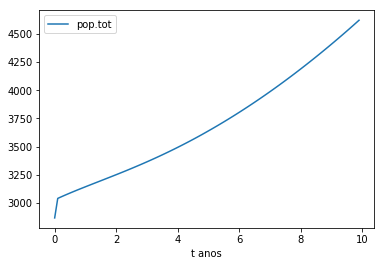

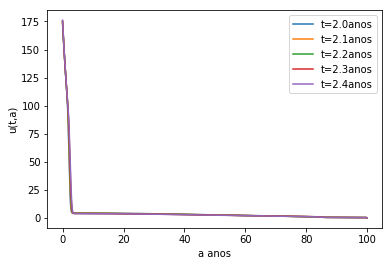

In [919]:
# populaçao total em funçao do tempo
plt.plot(It,[sum(uts[t]) for t in range(nt)],label='pop.tot')
plt.xlabel('t anos')
plt.legend()
plt.show()

#primeiras distribuiçoes t peq.
for i in range(20,25):
    plt.plot(Ia,uts[i],label='t='+str(int(i*dt*100)/100)+'anos')
plt.xlabel('a anos')
plt.ylabel('u(t,a)')
plt.legend()
plt.show()


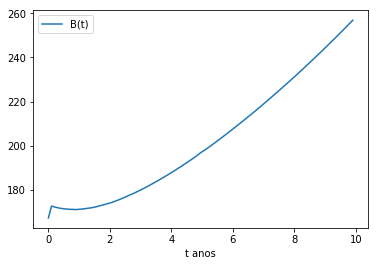

In [920]:
# funçao de nascimentos B(t)
plt.plot(It,[B[j] for j in range(nt)], label='B(t)')
plt.xlabel('t anos')
plt.legend()
plt.show()

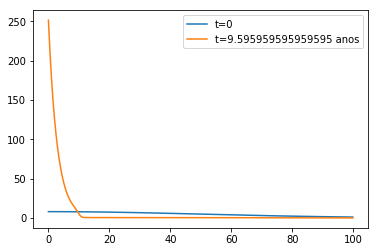

populacao total final: 4620.431774067431


In [921]:
# plotando t mapsto ut
isnap =5
plotar_uts_popul(isnap, It, tmax, uts)


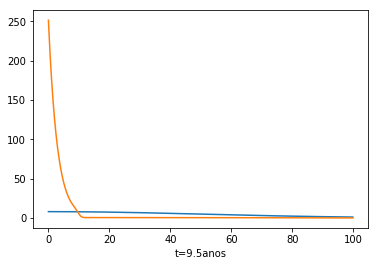

In [882]:
# gerando um gif
isnap = 5   # frequencia de ploteo
tempos = [it for it in range(nt) if it % isnap == 0]
intervalo_gif = 10*len(tempos) # quanto maior o intervalo_gif, mais tempo vai ficar em cada frame na reproducao
# gerar_gif(isnap,tempos,uts,'populacao_cresce',intervalo_gif)


![](./figs/populacao_cresce.gif)

## agora cresce!

# Eq. de Poisson 2d

- incógnita $u:D \subset \mathbb{R}^2 \to \mathbb{R}$
$$ \partial_x^2 u + \partial_y^2 u = f(x,y)$$
com $f$ função dado.


- veremos caso particular de condições de bordo (Dirichlet): todos os nodos do bordo estão dados
$$ u|_{\partial D} = h : \partial D \to \mathbb{R}$$

### Discretizaçao num dominio retangular $D=[0,L_x]\times [0,L_y]$

- [Eq. de Poisson discreta](https://en.wikipedia.org/wiki/Discrete_Poisson_equation)
- consideramos discretização com $\Delta x = \Delta y$,
$$ u(i,j) := u(i \Delta x, j \Delta y),\  i=0,..,n_x-1, \ j=0,..,n_y-1$$
- os valores $u(i,j)$ correspondientes ao interior de $D$ podem ser compilados em um vetor (ordenados "naturalmente")
$$ U = (u(1,1),u(2,1),u(3,1),...,u(n_x-2,1),u(1,2),u(2,2),...) $$
de tamanho $(n_x-2) (n_y -2)$
- pensando no laplaciano discreto, a eq. em diferenças finitas toma a forma:
$$ \delta^2_x u + \delta^2_y u (i,j) = \frac{1}{\Delta x^2} ( u(i+1,j)+u(i-1,j)+u(i,j+1)+u(i,j-1)-4u(i,j)) = f(i,j)$$
- as condições de bordo são $u(i,j) = h(i,j)$ para $(i,j)$ representando pontos no bordo

- pode-se juntar todas as eqs. algebricas resultantes em um grande sistema linear da forma
$$ A U = b $$
onde $A$ é uma matriz quadrada com $(n_x-2) (n_y -2)$ linhas, que é esparça com entradas $0,-1$ ou $4$, e $b$ é um vetor que tem of $f(i,j)$ correspondentes ao interior de $D$ assim como os $h(i,j)$ correspondentes ao bordo
- como $A$ é esparça, o sistema pode-se resolver em muitos casos, obtendo a aproximação numérica $u(i,j)$ para $u(x,y)$

**Obs**: uma modelagem concreta consiste em que $u(x,y)$ descreve o potencial eletrico gerado por uma distribuição de carga $\rho(x,y)$ via $f(x,y) = -\rho(x,y)/\epsilon_0$ ([wiki](https://en.wikipedia.org/wiki/Electric_potential)). 

Se tem uma superficie conductora $\Sigma$, $u$ tem uma condiçao de bordo nesta superficie: $u|_\Sigma$ é constante (suponhamos zero se o condutor está conectado 'a terra'). 

É interessante achar o potencial eletrico dado por diversas distribuicoes de carga e configuracoes de superficies condutoras (verificar ['cargas imagens'](https://en.wikipedia.org/wiki/Method_of_image_charges)).

![](./figs/cargas_eletricas.png)

### ficará como o exercicio do dia !

# Um modelo bi-dimensional para ondas sismicas (feito pelo Prof. Ricardo)

- consideramos uma onda acústica propagandose na rocha, cuja amplitude na posição $(x,z)$ ($z$ profundidade) a tempo $t$ é $p(x,z,t)$
- a propagação desta onda está modelada pela EDP (tipo eq. de onda)
$$
\ddot{p}(x,z,t) \ = \ c(x,z)^2 (\partial_x^2 p(x,z,t) + \partial_z^2 p(x,z,t)) \ + s(x,z,t)
$$



- a velocidade de propagação $c(x,z)$ depende de datos geologicos:

velocidade para tipos de rocha comuns:

| Rock Type | Velocity (m/s) |
| ----------|:--------------:|
| Unconsolidated Sandstone | 4600 - 5200 |
| Consolidated Sandstone | 5800 |
| Shale |1800 - 4900 |
| Limestone | 5800 - 6400 |
| Dolomite | 6400 - 7300 |
| Anhydrite | 6100 |
| Granite |5800 - 6100 |
| Gabbro | 7200 |


### Discretizando:

- Indices acima denotam direção $t$ e embaixo denotam direçoes $x,z$
$$
 \frac{p_{j,k}^{n+1} - 2 p_{j,k}^n + p_{j,k}^{n-1}}{\mathrm{d}t^2} \ = \ c_j^2 ( \partial_x^2 p + \partial_z^2 p) \ + s_{j,k}^n
$$

- para achar os $p_{j,k}^{n+1}$, propomos

$$
p_{j,k}^{n+1} \ = \ c_j^2 \mathrm{d}t^2 \left[ \partial_x^2 p + \partial_z^2 p \right]
+ 2p_{j,k}^n - p_{j,k}^{n-1} + \mathrm{d}t^2 s_{j,k}^n
$$

onde as derivadas espaciais são:

$$
\partial_x^2 p \ = \ \frac{p_{j+1,k}^{n} - 2 p_{j,k}^n + p_{j-1,k}^{n}}{\mathrm{d}x^2}
$$
$$
\partial_z^2 p \ = \ \frac{p_{j,k+1}^{n} - 2 p_{j,k}^n + p_{j,k-1}^{n}}{\mathrm{d}z^2} 
$$

# Aproximação numerica em python:

In [891]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [897]:
# Parametros

Lx = 4000     # horizontal length of the spatial domain (in meters)
Lz = 2000     # maximum depth of the spatial domain (in meters)
Tmax = 1      # Simulation time, in seconds
nx = 400      # grid points in x, e.g. 500
nz = 400      # grid points in z, e.g. 500
dx = Lx/nx    # grid increment in x direction 
dz = Lz/nz    # grid increment in z direction
c0 = 3000.0    # velocity (can be an array) (in meters per second)
dt = min(dx,dz)/2/np.max(c0)    # Time step (in seconds)
nt = int(Tmax / dt) # number of time steps
isx = nx // 3 # source index in x coordinate (in grid point number)
isz = nz // 2 # source index in z coordinate (in grid point number)
#isx = nx // 3
#isz = nz // 2
ist = 100     # shifting of source time function (?)
f0 = 150.0    # dominant frequency of source (in Hz)
isnap = 10    # snapshot frequency (in time steps)
T = 1.0 / f0  # dominant period (in seconds)
nop = 5       # number of grid points in the discrete spatial 2nd derivative operator

# Receiver locations
irx = np.array([3*nx//10 , 4*nx//10, 5*nx//10, 6*nx//10, 7*nx//10])
irz = np.array([5, 5, 5, 5, 5])
#irx = np.array([6*nx//10, 8*nx//10])
#irz = np.array([nz//8,  nz//8])
seism = np.zeros((len(irx), nt))

# Initialize pressure at different time steps and the second
# derivatives in each direction
p = np.zeros((nz, nx))
pold = np.zeros((nz, nx))
pnew = np.zeros((nz, nx))
pxx = np.zeros((nz, nx))
pzz = np.zeros((nz, nx))

# Output Courant criterion
print(f'dx = {dx} m')
print(f'dz = {dz} m')
print(f'dt = {dt} s')
print(f'nt = {nt} points')
print(f'maximum velocity = {np.max(c0)} m/s')
print(f'Courant condition = {max(np.max(c0)*dt/dx, np.max(c0)*dt/dz)}')

dx = 10.0 m
dz = 5.0 m
dt = 0.0008333333333333334 s
nt = 1200 points
maximum velocity = 3000.0 m/s
Courant condition = 0.5


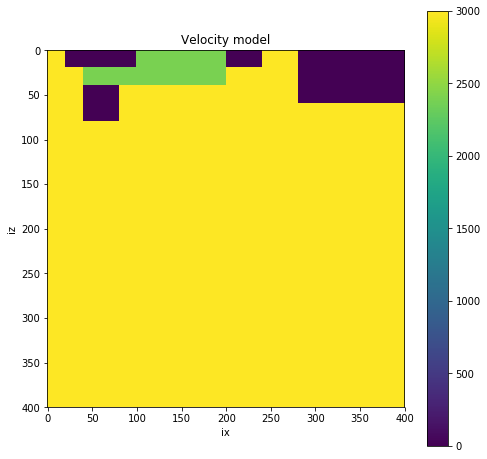

In [898]:
# Graficando o dominio onde a onda se propaga

# Model type, available are "homogeneous", "fault_zone",
# "surface_low_velocity_zone", "random", "topography",
# "slab"
model_type = "topography"

# Initialize velocity model (the fun bit!)
c = np.zeros((nz, nx))

if model_type == "homogeneous":
    c += c0
elif model_type == "fault_zone":
    c += c0
    c[:, nx // 2 - 5: nx // 2 + 5] *= 0.8    
elif model_type == "surface_low_velocity_zone":
    c += c0
    c[1:nz//20,:] *= 0.8
elif model_type == "random":
    pert = 0.4
    r = pert * np.random.rand(nz, nx)
    c += c0 * (1 - r)
elif model_type == "topography":
    c += c0
    c[0:nz//20, nx//20 : 5*nx//20] = 0                         
    c[0:nz//20, 10*nx//20 : 12*nx//20] = 0                  
    c[0:3*nz//20, 14*nx//20 : 16**nx//20] = 0
    c[2*nz//20: 4*nz//20, 2*nx//20: 4*nx//20]  = 0
    c[0 : 2*nz//20, 2*nx//20 : 10*nx//20] *= 0.8    
elif model_type == "slab":
    c += c0
    c[11*nz//20 : 12*nz//20, 0 : 12*nx//20] = 1.4 * c0
    for i in range(11*nx//20, 15*nx//20):
        c[i , i : i + 20 ] = 1.4 * c0
else:
    raise NotImplementedError
    
cmax = c.max()

# Plot the subterrain model 

plt.figure(figsize=(8, 8))

# The velocity model is influenced by the Earth model above
plt.title('Velocity model')
plt.imshow(c)
plt.xlabel('ix')
plt.ylabel('iz')
plt.colorbar()

plt.show()

![](./figs/dominio_sismog_pelado.png)

In [899]:
# definiendo a fonte da onda

# Source time function Gaussian, nt + 1 as we loose the last one by diff
src = np.empty(nt + 1)
for it in range(nt):
    src[it] = np.exp(-1.0 / T ** 2 * ((it - ist) * dt) ** 2)
# Take the first derivative
src = np.diff(src) / dt
src[nt - 1] = 0

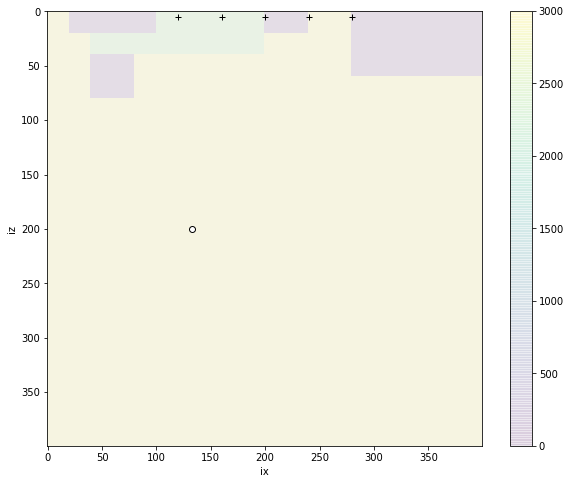

In [900]:
# Preparação para plotar

fig = plt.figure(figsize=(10,8))

v = max([np.abs(src.min()), np.abs(src.max())])

# Initialize animated plot
#image = plt.imshow(pnew, interpolation='nearest', animated=True,
#                   vmin=-v, vmax=+v, cmap=plt.cm.RdBu)

# Initialize animated plot
image = plt.imshow(pnew, interpolation='nearest', vmin=-v, vmax=+v, 
                   cmap=plt.cm.RdBu)

# Plot the receivers
for x, z in zip(irx, irz):
    plt.plot(x, z, 'k+')
    
plt.plot(isx, isz, 'ko', markerfacecolor='white')
plt.imshow(c, alpha = 0.1)
plt.colorbar()
plt.xlabel('ix')
plt.ylabel('iz')

#plt.ion()
plt.show(block=False)

#### Evolução temporal

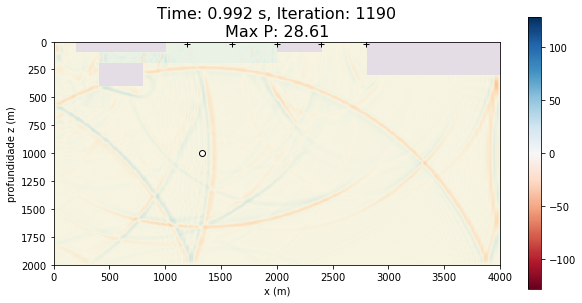

In [901]:
fig = plt.figure(figsize=(12,12))

image = plt.imshow(pnew, interpolation='nearest', vmin=-v, vmax=+v, 
                   extent=[0, Lx, 0, Lz], cmap=plt.cm.RdBu)

fig.show()

# Initialize pressure and the second derivatives in each direction
p = np.zeros((nz, nx))
pold = np.zeros((nz, nx))
pnew = np.zeros((nz, nx))
pxx = np.zeros((nz, nx))
pzz = np.zeros((nz, nx))

# indices required for seismograms
ir = np.arange(len(irx))

# Time evolution
for it in range(nt):
    if nop==3:
        # calculate partial derivatives, be careful around the boundaries
        pxx[:, 1:nx-2] = p[:, 2:nx-1] - 2*p[:,1:nx-2] + p[:, :nx-3]
        pzz[1:nz-2, :] = p[:nz-3, :] - 2 * p[1:nz-2, :] + p[2:nz-1, :]      
    elif nop==5:
        # calculate partial derivatives, be careful around the boundaries
        pxx[:, 2:nx-2] = -1./12*p[:,4:nx]+4./3*p[:,3:nx-1]-5./2*p[:,2:nx-2]+4./3*p[:,1:nx-3]-1./12*p[:,:nx-4]
        pzz[2:nz-2,:] = -1./12*p[4:nz,:]+4./3*p[3:nz-1,:]-5./2*p[2:nz-2,:]+4./3*p[1:nz-3,:]-1./12*p[:nz-4,:]
            
    pxx /= dx ** 2
    pzz /= dz ** 2

    # Time extrapolation
    pnew = 2 * p - pold + dt ** 2 * c ** 2 * (pxx + pzz)
    # Add source term at isx, isz
    pnew[isz, isx] = pnew[isz, isx] + src[it]

    # Plot every isnap-th iteration
    if it % isnap == 0:    # you can change the speed of the plot by increasing the plotting interval
        
        plt.figure(figsize=(10,5))
        pmax = p.max()
        title_str = f"Time: {it*dt:.3f} s, Iteration: {it}\n"
        if 0.01 <= pmax < 999.99:
            title_str += f"Max P: {pmax:.2f}"
        else:
            title_str += f"Max P: {pmax:.2e}"
        plt.title(title_str, fontsize=16)
        # Plot the receivers
        
        plt.plot(isx*dx, isz*dz, 'ko', markerfacecolor='white')

        plt.xlabel('x (m)')
        plt.ylabel('profundidade z (m)')
        
        plt.imshow(pnew, interpolation='nearest', vmin=-v, vmax=+v, 
                   extent=[0, Lx, Lz, 0], cmap=plt.cm.RdBu)
        
        plt.colorbar()
        
        plt.imshow(c, extent=[0, Lx, Lz, 0], alpha=0.1)

        for i, j in zip(irx, irz):
            plt.plot(i*dx, j*dz, 'k+')
            
        clear_output(wait = True)
        plt.pause(0.1)

    pold, p = p, pnew

    # Save seismograms
    seism[ir, it] = p[irz[ir], irx[ir]]

![](./figs/sismografia.png)

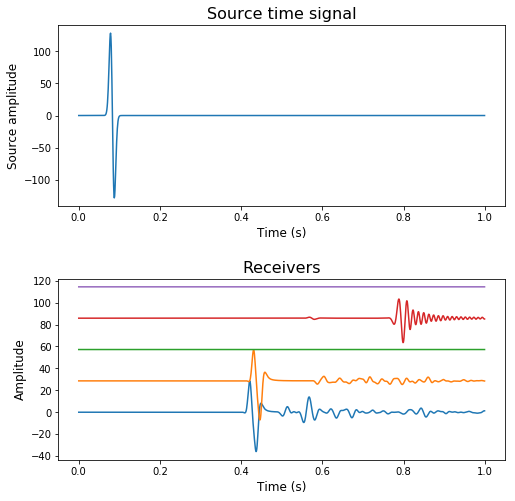

In [902]:
# Plotando o que medem os sismografos!

plt.figure(figsize=(8, 8))

plt.subplot(211)
time = np.arange(nt) * dt
plt.plot(time, src)
plt.title('Source time signal', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Source amplitude', fontsize=12)


plt.subplot(212)
ymax = seism.ravel().max()
for ir in range(len(seism)):
    plt.plot(time, seism[ir, :] + ymax * ir)
    plt.title('Receivers', fontsize=16)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)

plt.subplots_adjust(hspace=0.4)
plt.show()

![](./figs/sismografos_sinal.png)

# Exercicios:

#### (*) resolver a eq. de Poisson 2d: 
pensando que $u$ é o potencial elétrico e que $f(x,y) = -\rho(x,y)/\epsilon_0$ esta dado por uma distribuição de carga eletrica, pensando que o bordo $\partial D$ é um condutor a terra ($u|_{\partial D}=0$). Depois, colocar sub-compartimentos condutores (eg: dividir a caixa em 2) e verificar que aparecem "cargas imagem".

##### Outros:
- fazer um ajuste dos parametros $k$ e $\epsilon$ no modelo do café modificado.
- fazer um modelo 3d para a difusão do calor em uma caneca com café quente. Pensar $u\equiv u(t,r,\theta,z)$ em coordenadas cilindricas $(r,\theta,z)$, por simplicidade assumir independencia em $\theta$, usar que o Laplaciano em coords. cilindricas ([wiki](https://en.wikipedia.org/wiki/Laplace_operator)):
$$ \Delta f = \frac{1}{r} \frac{\partial }{\partial r}(r \frac{\partial f}{\partial r}) + \frac{1}{r^2}\frac{\partial^2 f}{\partial \theta^2} + \frac{\partial^2 f}{\partial z^2} $$
- modificar os parametros do modelo de distribuicao populacional, achando distribuições 'realistas' (ver [ Mathematical Models in Biology, Christina Kuttler](http://www-m6.ma.tum.de/~kuttler/script1.pdf) Seção 4.2).
- - Considerar as autofunções do operador $-\partial_a - \mu(a)$ para entender analiticamente o comportamento das solucoes
- variar parametros no codigo de ondas sismicas para entender o funcionamento